In [1]:
from datetime import datetime, timedelta
from pandas_datareader import data
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

In [6]:
def get_company_stock(start, end, company_code):
  #yf.pdr_override()
  #df = data.get_data_yahoo(company_code)
  #df = df[(df.index >= start) & (df.index <= end)]
  df = yf.download(company_code, start=start, end=end, interval='1d')
  return df

def sma(df, date, price):
  span01 = 5
  span02 = 25
  span03 = 50

  df['sma01'] = price.rolling(window = span01).mean()
  df['sma02'] = price.rolling(window = span02).mean()
  df['sma03'] = price.rolling(window = span03).mean()

  sma01 = df['sma01']
  sma02 = df['sma02']
  sma03 = df['sma03']
  golden_cross = []
  dead_cross = []

  for i in range(len(sma03)):
    if(i == span03):
      dif13_prev = sma01[i] - sma03[i]
      dif23_prev = sma02[i] - sma03[i]
    elif(i > span03):
      dif13 = sma01[i] - sma03[i]
      dif23 = sma02[i] - sma03[i]

      if(dif13_prev * dif13 < 0):
        if(dif13 > 0):
          golden_cross.append(date[i])
        elif(dif13 < 0):
          dead_cross.append(date[i])
      elif(dif23_prev * dif23 < 0):
        if(dif23 > 0):
          golden_cross.append(date[i])
        elif(dif23 < 0):
          dead_cross.append(date[i])

      dif13_prev = sma01[i] - sma03[i]
      dif23_prev = sma02[i] - sma03[i]

  return golden_cross, dead_cross

def calculate_ema(price, period):
  ema = np.zeros(price.size)
  temp = 0
  for i in range(price.size):
    if(i < period - 1):
      temp += price[i]
      ema[i] = np.nan
    elif(i == period - 1):
      temp += price[i]
      ema[i] = temp / period
    else:
      ema[i] = ema[i - 1] + 2 * (price[i] - ema[i - 1]) / (period + 1)
  return ema

def calculate_signal(macd, slow_period, signal_period):
  signal = np.zeros(macd.size)
  temp = 0
  for i in range(macd.size):
    if(i < slow_period - 1):
      signal[i] = np.nan
    elif(i < slow_period + signal_period - 2):
      temp += macd[i]
      signal[i] = np.nan
    elif(i == slow_period + signal_period - 2):
      temp += macd[i]
      signal[i] = temp / signal_period
    else:
      signal[i] = signal[i - 1] + 2 * (macd[i] - signal[i - 1]) / (signal_period + 1)
  return signal

def calculate_macd(df, price):
  fast_period = 12
  slow_period = 26
  signal_period = 9

  ema_fast = calculate_ema(price, fast_period)
  ema_slow = calculate_ema(price, slow_period)
  macd = ema_fast - ema_slow
  signal = calculate_signal(macd, slow_period, signal_period)
  macd_hist = macd - signal
  df['macd'] = macd
  df['signal'] = signal
  df['macdhist'] = macd_hist

def calculate_rsi(df, price):
  timeperiod = 14

  rsi = np.zeros(price.size)
  increase = 0
  decrease = 0
  mean_increase = 0
  mean_decrease = 0
  for i in range(price.size):
    if(i == 0):
      rsi[i] = np.nan
    else:
      if(i > timeperiod):
        increase = mean_increase * (timeperiod - 1)
        decrease = mean_decrease * (timeperiod - 1)

      if(price[i] - price[i - 1] > 0):
        increase += (price[i] - price[i - 1])
      elif(price[i] - price[i - 1] < 0):
        decrease += (price[i - 1] - price[i])

      if(i < timeperiod):
        rsi[i] = np.nan
      else:
        mean_increase = increase / timeperiod
        mean_decrease = decrease / timeperiod
        rsi[i] = 100 * mean_increase / (mean_increase + mean_decrease)
  df['rsi'] = rsi

def calculate_bband(df, price):
  timeperiod = 20
  nbdevup = 2
  nbdevdn = 2

  middle = price.rolling(window = timeperiod).mean()
  stdev = price.rolling(window = timeperiod).std()
  upper = middle + nbdevup * stdev
  lower = middle - nbdevdn * stdev

  df['upper'] = upper
  df['middle'] = middle
  df['lower'] = lower

def ichimoku(df):
  high = df['High']
  low = df['Low']

  max26 = high.rolling(window=26).max()
  min26 = low.rolling(window=26).min()

  df['basic_line'] = (max26 + min26) / 2

  high9 = high.rolling(window=9).max()
  low9 = low.rolling(window=9).min()

  df['turn_line'] = (high9 + low9) / 2

  df['span1'] = (df['basic_line'] + df['turn_line']) / 2

  high52 = high.rolling(window=52).max()
  low52 = low.rolling(window=52).min()

  df['span2'] = (high52 + low52) / 2

  df['slow_line'] = df['Adj Close'].shift(-25)

def show_analysis_results(start, end, company_code):
  df = get_company_stock(start, end, company_code)

  date = df.index
  price = df['Adj Close']
  gcross, dcross = sma(df, date, price)
  calculate_macd(df, price)
  calculate_rsi(df, price)
  calculate_bband(df, price)
  ichimoku(df)

  plt.figure(figsize = (20, 30))
  plt.subplot(6, 1, 1)
  plt.plot(date, price, label = 'Close')
  plt.plot(date, df['sma01'], label = 'sma01')
  plt.plot(date, df['sma02'], label = 'sma02')
  plt.plot(date, df['sma03'], label = 'sma03')
  for i in range(len(gcross)):
    plt.vlines(gcross[i], price.min(), price.max(), color = 'r', linestyles = 'dotted')
  for i in range(len(dcross)):
    plt.vlines(dcross[i], price.min(), price.max(), color = 'b', linestyles = 'dotted')
  plt.legend()

  plt.subplot(6, 1, 2)
  plt.bar(date, df['Volume'], label = 'Volume', color = 'grey')
  plt.legend()

  plt.subplot(6, 1, 3)
  plt.fill_between(date, df['macdhist'], color="grey", alpha=0.5, label='MACD_hist')
  plt.hlines(0, date.max(), date.min(), color='grey', linestyles='dashed')
  plt.legend()

  plt.subplot(6, 1, 4)
  plt.plot(date, df['rsi'], label='RSI', color='grey')
  plt.ylim(0, 100)
  plt.hlines([30, 50, 70], date.min(), date.max(), 'grey', linestyles='dashed')
  plt.legend()

  plt.subplot(6, 1, 5)
  plt.plot(date, price, label='Close')
  plt.fill_between(date, df['upper'], df['lower'], color='grey', alpha=0.3, label='BBAND')
  plt.legend()

  plt.subplot(6, 1, 6)
  plt.plot(date, price, label='Close')
  #plt.plot(df['basic_line'], label='basic')
  #plt.plot(df['turn_line'], label='turn')
  plt.fill_between(date, df['span1'], df['span2'], facecolor='grey', alpha=0.5, label='span')
  plt.plot(date, df['slow_line'], label='slow')
  plt.legend()
  plt.grid()

def show_price_prediction(start, end, company_code):
  data_master = get_company_stock(start, end, company_code)

  data_master['weekday'] = data_master.index.weekday
  data_technical = data_master.copy()

  SMA1 = 5
  SMA2 = 10
  SMA3 = 15
  data_technical['SMA1'] = data_technical['Adj Close'].rolling(SMA1).mean()
  data_technical['SMA2'] = data_technical['Adj Close'].rolling(SMA2).mean()
  data_technical['SMA3'] = data_technical['Adj Close'].rolling(SMA3).mean()

  data_technical['Body'] = data_technical['Open'] - data_technical['Adj Close']

  data_technical['Close_diff'] = data_technical['Adj Close'].diff(1)

  data_technical['Close_next'] = data_technical['Adj Close'].shift(-1)

  data_technical = data_technical.dropna(how='any')

  data_technical = data_technical[['High', 'Low', 'Open', 'Adj Close', 'Body', 'Close_diff', 'SMA1', 'SMA2', 'SMA3', 'Close_next']]


SMA:単純移動平均<br>
ゴールデンクロス（赤点線）:上昇トレンド<br>
デッドクロス（青点線）:下降トレンド<br><br>
MACD:macd_histが0 以上で上昇トレンド、0以下で下降トレンド<br><br>
RSI:30以下で売られ過ぎ→買い、70以上で買われ過ぎ→売り<br><br>
ボリンジャーバンド（BBAND）:株価が下にはみ出すと売られ過ぎ→買い、上にはみ出すと買われ過ぎ→売り<br><br>
一目均衡表:株価が雲を下から上に抜ける→上昇トレンド、株価が雲を上から下に抜ける→下降トレンド、遅行線が株価を上回る→買いサイン

[*********************100%%**********************]  1 of 1 completed


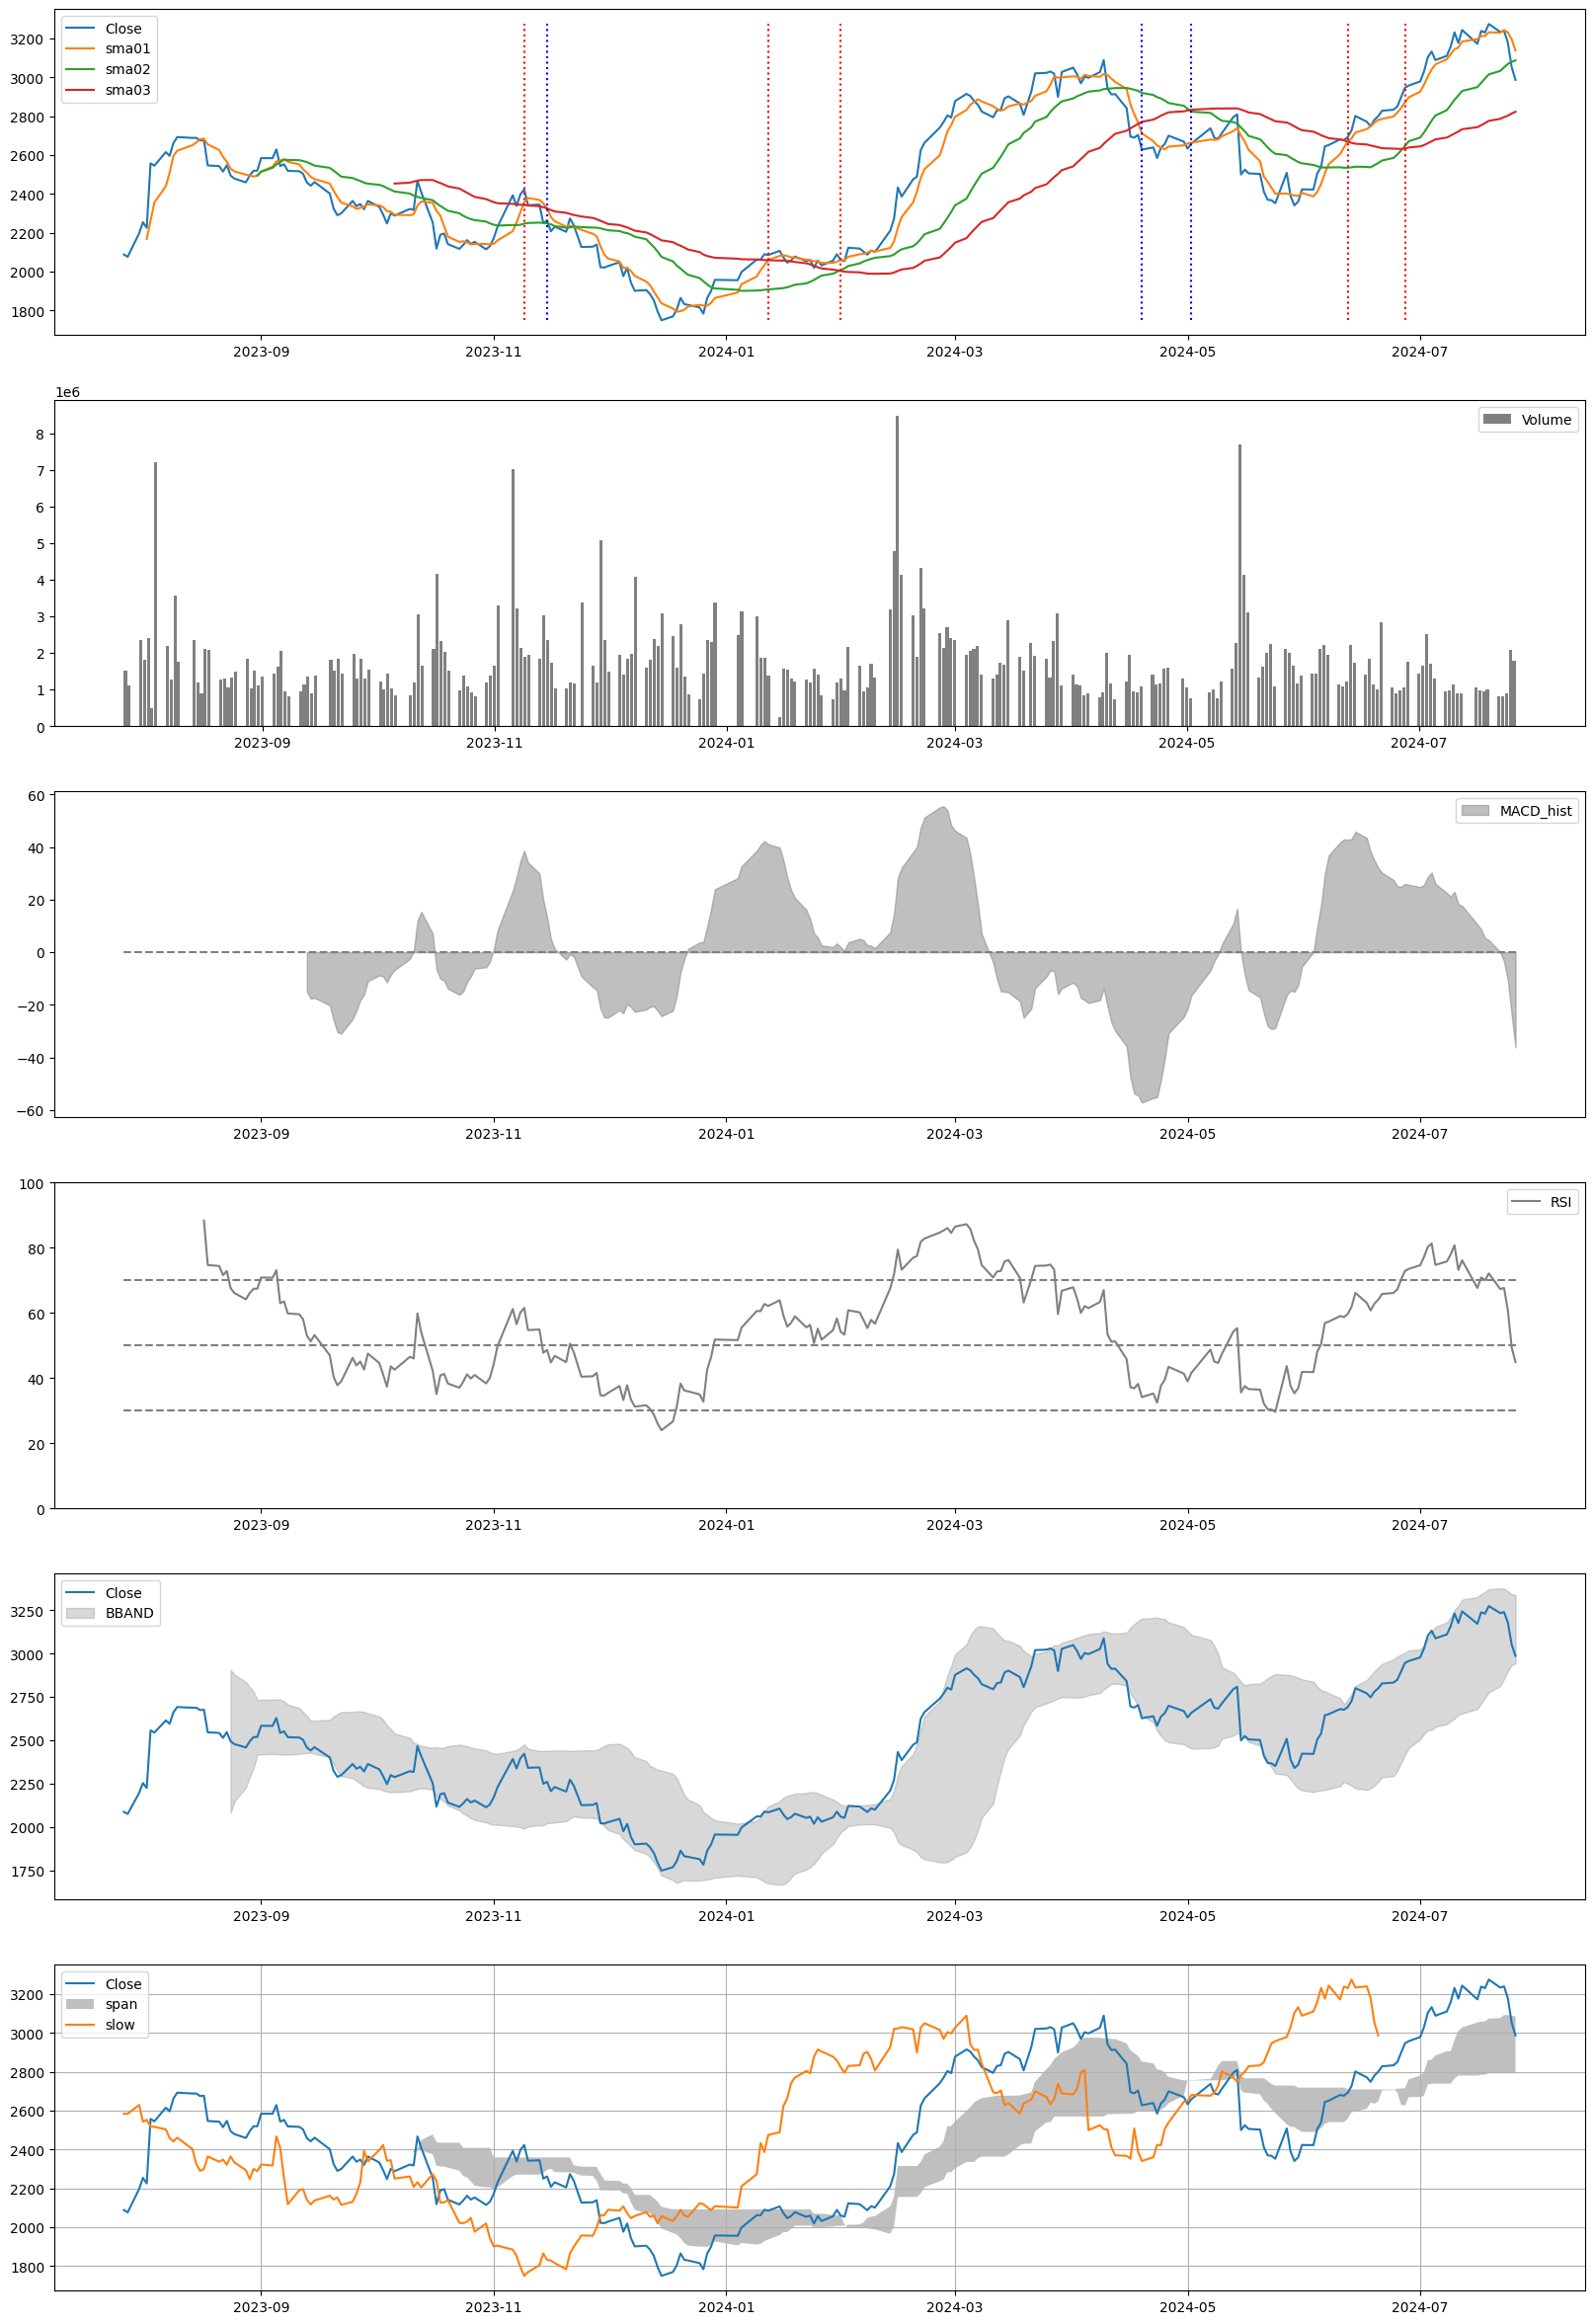

In [8]:
show_analysis_results('2023-07-27', '2024-07-27', '8136.T')